**By Arian Tashakkor - 40023494**

# Summary

In June of 2014, the culmination of the works of Ian Goodfellow and his colleagues resulted in a machine learning framework that we now know as Generative Adversarial Networks (GANs). In essence, although their objective differs from that of classical competitive learning neural networks such as LVQ or Hamming nets, GANs are also by definition, competitive networks.

In GANs, there are two subnetworks usually referred to as the Generator and the Discriminator (or the Actor and the Critic) that play a zero-sum minimax game where the loss of one subnetwork is directly correlated with the gain of the other. The Generator tries to generate samples that are real enough to fool the Discriminator, while the Discriminator tries to learn how to better discriminate between real and fake samples in order to not be fooled by the Generator. 

The idea is that as both networks learn over time and become stronger, we are left with a strong Generator that is able to generate samples very close to the real data.

# Technical Details

More concretely, we are aiming to learn the Generator's distribution $p_g$ over data $x$ so that $p_g$ is as close as possible to $p_{data}$, the distribution from which the real samples are drawn. Suppose $D(x)$ represents the output of the discriminator over input $x$, and $G(z)$ represents the out of the Generator from sample noise $z$.

![GAN Architecture](imgs/gan.png)

We train $D$ to maximize the probability of assigning the correct label to both the training examples and samples from G (fake samples). Concurrently, we also train G to minimize negative log likelihood of Discriminator loss $log(1 - D(G(z)))$. This means that $D$ and $G$ play a two-player minimax game game with value function $V(G,D)$:

$$
\min_G \max_D V(D,G) = E_{x\sim p_{data}(x)}[logD(x)] + E_{x\sim p_z}(z)[log(1 - D(G(z)))]
$$

In other words, the discriminator $D$ tries to maximize the game value (increasing the expectation of classification result over real samples $x$ and decrease the expectation of classification result over fake samples $G(z)$), while the generator $G$ tries to minimize the game value, trying to achieve an objective in direct opposition of the discriminator.

It can be shown that this minimax game has a global optimum for $p_g = p_{data}$, meaning that the generator can generate samples that look like they were drawn from the original real samples.

However, note that the generator is not "memorizing" the samples because the input to generator is a random noise that can be altered. Therefore, we learn the *distribution* of the real samples and through altering the random noise input of the generator we can generate genuinely original samples that look a lot like actual real samples!

# Implementation
In order to showcase the power of the most primitive version of GAN as described in 2014 paper by Goodfellow, et al., we will attempt to generate fake digits resembling real handwritten samples from the famous MNIST dataset.


We will begin by importing some useful packages and the dataset we will use to build and train our GAN. We will also use a visualizer function to help us investigate the output images of our GAN.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## MNIST Dataset
The training images our discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](imgs/MnistExamples.png)

You may notice that the images are quite pixelated -- this is because they are all only 28 x 28 which makes MNIST ideal for simple training.

## Generator
The first step is to build the generator component.

We will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map the input to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (we will use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) so the output can be transformed in complex ways.

In [2]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

Now we can build the generator class. It will take 3 input arguments:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these arguments, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST).

Finally, we will use a forward pass function that takes in a noise vector and generates an image of the output dimension using our neural network.


In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise
To be able to use our generator, we will need to be able to create noise vectors. The noise vector $z$ has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. We will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, we will generate all the noise vectors at once.

In [4]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn((n_samples, z_dim), device=device)

## Discriminator
The second component that we need to construct is the discriminator. As with the generator component, we will start by creating a function that builds a neural network block for the discriminator.

*Note: we use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient.* 


REctified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![](imgs/relu-graph.png)  |  ![](imgs/lrelu-graph.png)





In [5]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

Now we can use these blocks to make a discriminator. The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. **This output classifies whether an image is fake or real**.


In [6]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Training
Now we can put it all together!
First, we will set our parameters:

- `criterion`: the loss function
- `n_epochs`: the number of times we iterate through the entire dataset when training
- `z_dim`: the dimension of the noise vector
- `display_step`: how often to display/visualize the images
- `batch_size`: the number of images per forward/backward pass
- `lr`: the learning rate
- `device`: the device type, here using a GPU (which runs CUDA), not CPU

Next, we will load the MNIST dataset as tensors using a dataloader.



In [7]:
# Setting the parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 10000
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Now, we can initialize our generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [8]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before we train our GAN, we will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves.

In [9]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    noise_vecs = get_noise(num_images, z_dim, device)
    fakes = gen(noise_vecs)  
    disc_preds_fake = disc(fakes.detach())
    fake_ground_truths = torch.zeros_like(disc_preds_fake)
    fake_loss = criterion(disc_preds_fake, fake_ground_truths)
    disc_preds_real = disc(real)
    real_ground_truths = torch.ones_like(disc_preds_real)
    real_loss = criterion(disc_preds_real, real_ground_truths)
    disc_loss = (real_loss + fake_loss)/2
    return disc_loss

In [10]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise_vecs = get_noise(num_images, z_dim, device)
    fakes = gen(noise_vecs)  
    disc_preds_fake = disc(fakes)
    fake_ground_truths = torch.ones_like(disc_preds_fake)
    gen_loss = criterion(disc_preds_fake, fake_ground_truths)
    return gen_loss

Finally, we can put everything together. For each epoch, we will process the entire dataset in batches. For every batch, we will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that we may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and was the primary subject of the future works on the original GAN.

Step 10000: Generator loss: 2.990274811393031, discriminator loss: 0.13278775974996365


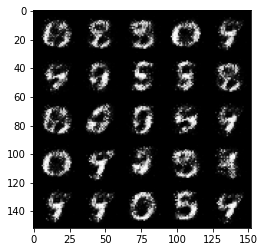

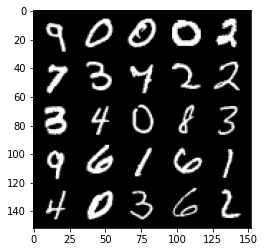

Step 20000: Generator loss: 3.653365837502476, discriminator loss: 0.10878905855044729


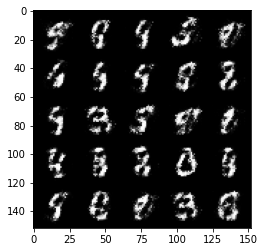

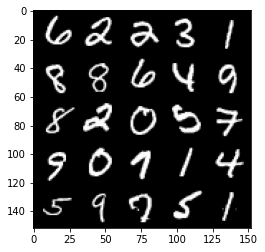

Step 30000: Generator loss: 2.9730004381418293, discriminator loss: 0.18190171144604678


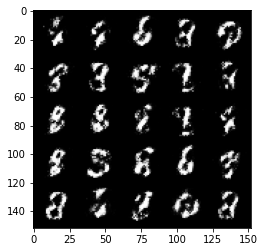

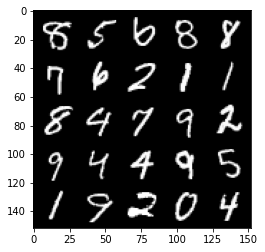

Step 40000: Generator loss: 2.3919541805267404, discriminator loss: 0.2515606967136265


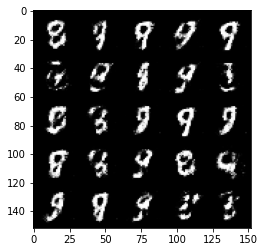

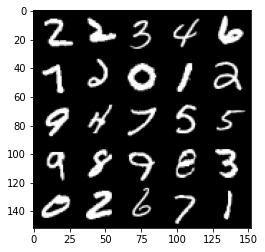

Step 50000: Generator loss: 2.102341052448748, discriminator loss: 0.29543063737750286


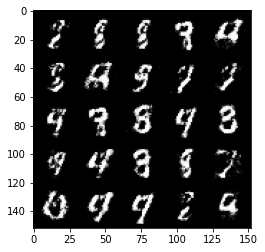

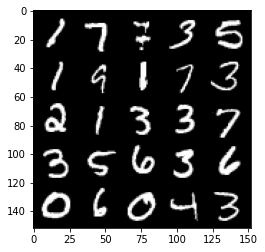

Step 60000: Generator loss: 1.8436075557589522, discriminator loss: 0.3423363580986866


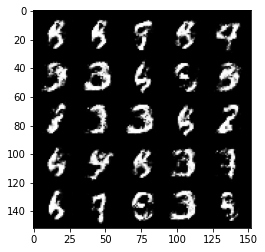

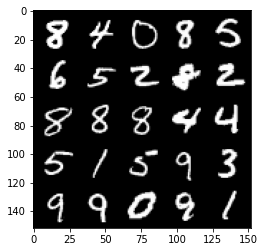

Step 70000: Generator loss: 1.6222465070843757, discriminator loss: 0.3904575144082296


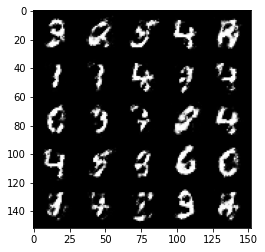

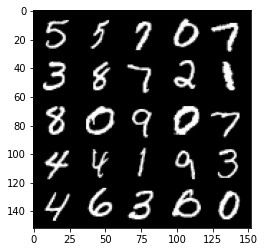

Step 80000: Generator loss: 1.5439904988408097, discriminator loss: 0.4024484381437315


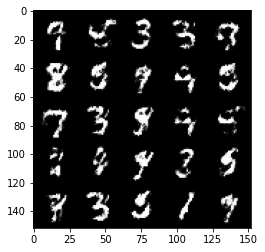

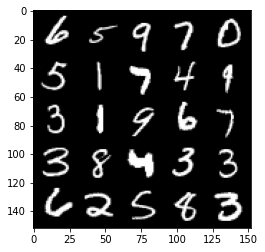

Step 90000: Generator loss: 1.4608604462742718, discriminator loss: 0.4211915430575617


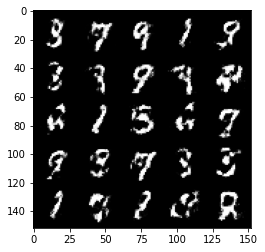

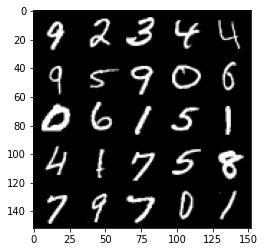

In [11]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in dataloader:
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


As we can see, the samples generated by the generator are slowly getting better over time as its loss function decreases. Because the generator is getting stronger, even though the discriminator is also trying to minimize its loss, we can see that the discriminator loss has an upward trend. Eventually the network reaches a state of equilibrium where neither of the subnetworks make any meaningful improvements to their learned weights.

# Conclusion

In this project, we took a look at the first iteration of Generative Adversarial Networks with complete with a working implementation. However, the first GAN architecture is not without its flaws which were addressed later in future works. We will briefly discuss some of them below:

- Non-convergence: the model parameters oscillate, destabilize and never converge.
- Mode Collapse: the generator, by chance, produces one real-looking sample and because the discriminator fails at detecting it, the generator collapses on that one sample, effectively converging to a point where all of its generated samples look alike.
- Diminishing Gradient: the discriminator becomes powerful to the point that the generator gradient vanishes and learns nothing.

To address some of these issues the following improvements have been proposed:

- [Wasserstein GAN](https://arxiv.org/abs/1701.07875)
- [Deep Convolutional GAN (DCGAN)](https://arxiv.org/abs/1511.06434)
- [GANs with Spectral Normalization (SNGAN)](https://arxiv.org/abs/1802.05957)